# Predicting Profitability and Popularity of movies
**In this notebook, we are going to build and test different models to:**

**1) Predict which movies would be profitable**

**2) Predict which movies would be popular**

# 1. Importing the libraries and the data that was obtained from the previous notebook - Data-cleaning

In [1]:
%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
#from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
#from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings('ignore')

/home/angps/anaconda3/envs/angps/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/angps/anaconda3/envs/angps/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
valid_data=pd.read_csv("/home/angps/Documents/DSC3216 (1)/project/valid_data.csv")

In [3]:
valid_data.head(2)

,index,adult,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,tagline,title,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,top_cast,top_crew,Spring,Summer,Autumn
0,9,False,3512454,['Drama'],110428,fr,"Winter, 1915. Confined by her family to an asy...",0.134014,[],['France'],2013-03-13,115860.0,95.0,NaN,Camille Claudel 1915,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"['Juliette Binoche', 'Robert Leroy']","['Bruno Dumont', 'Bruno Dumont']",1,0,0
1,15,False,40000000,"['Adventure', 'Drama']",77221,en,"On the Arabian Peninsula in the 1930s, two war...",6.652197,[],"['France', 'Italy', 'Qatar', 'Tunisia']",2011-12-21,5446000.0,130.0,NaN,Black Gold,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"['Mark Strong', 'Antonio Banderas']","['Menno Meyjes', 'James Horner']",0,0,0


# 2) Getting the required variables for regression and classification
**We would drop those non-numerical variables (e.g index,adult,id,overview etc) in order to perform regression and classification**

In [4]:
valid_data_models=valid_data.copy()
valid_data_models.drop(["index","adult","genres","id","original_language","overview","production_companies","production_countries","release_date","tagline","title","top_cast","top_crew"],inplace=True,axis=1)

In [5]:
valid_data_models.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,Spring,Summer,Autumn
0,3512454,0.134014,115860.0,95.0,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,40000000,6.652197,5446000.0,130.0,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,30000000,10.342202,160259319.0,111.0,6.1,1013.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,25000000,12.868098,170764026.0,85.0,6.4,2297.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35000000,7.852170,32483410.0,101.0,5.9,241.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 3) Inserting profitability and popularity measures
**We use the simple (Revenue-Cost)/Cost formula to determine if a movie is profitable. We would require a result of at least 2x to be deemed worthy to invest in.**

**We use the weighted ratings formula used by Imdb and will only classify the top 25% of the weighted ratings as movies that are popular.**

In [6]:
#For profitability:
def simple_profit(x):
    return (x["revenue"]-x["budget"])/(x["budget"])

#For popularity:
vote_counts = valid_data_models[valid_data_models['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = valid_data_models[valid_data_models['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [7]:
valid_data_models["Profitability"]=valid_data_models.apply(simple_profit,axis=1)
valid_data_models["is_profitable"]=np.where(valid_data_models["Profitability"]>2,1,0)
valid_data_models["Weighted_ratings"]=valid_data_models.apply(weighted_rating,axis=1)
#We shall classify the top 25% of the weighted ratings of the movies as being popular. 
valid_data_models["is_popular"]=np.where(valid_data_models["Weighted_ratings"]>=valid_data_models["Weighted_ratings"].quantile(0.75),1,0)
valid_data_models.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,Spring,Summer,Autumn,Profitability,is_profitable,Weighted_ratings,is_popular
0,3512454,0.134014,115860.0,95.0,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.967015,0,5.786743,0
1,40000000,6.652197,5446000.0,130.0,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.863850,0,5.783303,0
2,30000000,10.342202,160259319.0,111.0,6.1,1013.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.341977,1,5.840466,0
3,25000000,12.868098,170764026.0,85.0,6.4,2297.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.830561,1,5.992170,1
4,35000000,7.852170,32483410.0,101.0,5.9,241.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.071903,0,5.787390,0


In [8]:
valid_data_models.to_csv("Valid_data_models.csv",index=False)

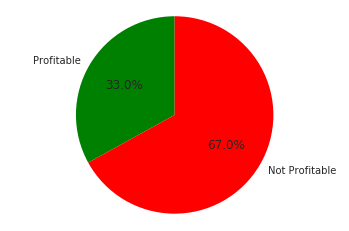

In [9]:
labels="Profitable","Not Profitable"
sizes=[sum(valid_data_models["is_profitable"]==1),sum(valid_data_models["is_profitable"]==0)]
colors=["green","red"]
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%',startangle=90)
 
plt.axis('equal')
plt.show()

**Only about 33% of the movies are "profitable"**

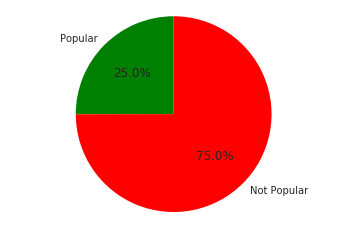

In [10]:
labels="Popular","Not Popular"
sizes=[sum(valid_data_models["is_popular"]==1),sum(valid_data_models["is_popular"]==0)]
colors=["green","red"]
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%',startangle=90)
 
plt.axis('equal')
plt.show()

**About 25% of the movies are "popular" **

# 4) Regression and Classification Models

**We would be performing the following methods to understand and predict Profitability and Popularity of movies**

1. Multi Linear Regression
2. Logistic Regression
3. SVM
4. Decision Tree/Classification Tree
5. Random Forest
6. XGBoost

# 4.1  Regression and Classification for PROFITABILITY

# 4.1.1 Multi-Linear Regression

In [11]:
import statsmodels.api as sm
X=valid_data_models.drop(["is_profitable","Profitability","revenue","popularity","vote_average","vote_count","is_popular","budget"],axis=1)
Y=valid_data_models["revenue"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     52.82
Date:                Mon, 16 Apr 2018   Prob (F-statistic):          1.10e-260
Time:                        16:14:08   Log-Likelihood:                -42046.
No. Observations:                2062   AIC:                         8.416e+04
Df Residuals:                    2026   BIC:                         8.437e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
runtime             1.769e+06   2.28e+05      7.748      0.000    1.32e+06    2.22e+06
Animation           8.531e+07   2.12e+07      4.029      0.000    4.38e+07    1.27e+08
Crime               -2.53e+07   1.25e+07     -2.021      0.043   -4.99e+07   -7.52e+05
History            -4.888e+07   2.04e+07     -2.397      0.017   -8.89e+07   -8.89e+06
Horror             -4.459e+07   1.55e+07     -2.877      0.004    -7.5e+07   -1.42e+07
Drama              -7.432e+07   9.77e+06     -7.609      0.000   -9.35e+07   -5.52e+07
Mystery            -1.377e+07   1.59e+07     -0.865      0.387    -4.5e+07    1.74e+07
Documentary        -1.128e+08   3.84e+07     -2.941      0.003   -1.88e+08   -3.76e+07
Fantasy             7.368e+07   1.47e+07      5.010      0.000    4.48e+07    1.03e+08
Action              4.917e+07   1.05e+07      4.687      0.000    2.86e+07    6.97e+07
Thriller           -2.691e+07   1.07e+07     -2.523      0.012   -4.78e+07   -5.99e+06
Music              -2.234e+07   2.49e+07     -0.898      0.369   -7.11e+07    2.64e+07
Comedy             -5.195e+07      1e+07     -5.181      0.000   -7.16e+07   -3.23e+07
Family              5.487e+07   1.81e+07      3.037      0.002    1.94e+07    9.03e+07
Romance            -2.026e+06   1.14e+07     -0.177      0.859   -2.45e+07    2.04e+07
Western            -7.241e+07   4.07e+07     -1.779      0.075   -1.52e+08    7.42e+06
War                -2.027e+07   2.21e+07     -0.917      0.359   -6.37e+07    2.31e+07
Foreign             4.118e+06   4.68e+07      0.088      0.930   -8.77e+07    9.59e+07
Adventure           1.128e+08   1.21e+07      9.356      0.000    8.92e+07    1.36e+08
Western Europe     -6.176e+07   1.04e+07     -5.929      0.000   -8.22e+07   -4.13e+07
Middle Africa       3.294e+07   1.78e+08      0.185      0.853   -3.16e+08    3.81e+08
Northern Africa    -5.792e+07   1.04e+08     -0.558      0.577   -2.62e+08    1.46e+08
Central America    -8.009e+07   5.32e+07     -1.505      0.132   -1.84e+08    2.43e+07
North America      -2.298e+07   1.74e+07     -1.322      0.186   -5.71e+07    1.11e+07
Eastern Asia       -6.032e+07    2.1e+07     -2.870      0.004   -1.02e+08   -1.91e+07
South-Eastern Asia -5.677e+07    4.2e+07     -1.352      0.177   -1.39e+08    2.56e+07
Central Asia       -1.623e-08   6.73e-08     -0.241      0.810   -1.48e-07    1.16e-07
Western Asia       -8.129e+07   6.05e+07     -1.344      0.179      -2e+08    3.73e+07
Eastern Europe     -1.046e+08    1.9e+07     -5.495      0.000   -1.42e+08   -6.72e+07
Oceania            -2.892e+07   2.48e+07     -1.168      0.243   -7.75e+07    1.97e+07
Southern Africa     2.837e-09   1.57e-08      0.181      0.857    -2.8e-08    3.36e-08
Southern Asia      -1.486e+08   1.82e+07     -8.150      0.000   -1.84e+08   -1.13e+08
Caribbean           7.417e+07   5.66e+

**We will first split our training and test set (20%)**

**We will also remove variables that we do not know before a movie is released (e.g profitability, vote counts etc)**

In [12]:
from sklearn.model_selection import train_test_split
x=valid_data_models.drop(["budget","is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
y=valid_data_models["is_profitable"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

**We will use 5-fold cross validation**

In [13]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

**We will create functions to calculate the In-sample accuracy, Test accuracy and to plot our ROC curve and confusion matrix for classifying whether a movie would be PROFITABLE.**

In [14]:
def prof_train_acc_score(model):
    return np.mean(cross_val_score(model,x_train,y_train,cv=k_fold,scoring="accuracy"))
def prof_test_acc_score(model):
    return accuracy_score(y_test, model.predict(x_test))
def prof_test_prec_score(model):
    return precision_score(y_test,model.predict(x_test))

def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Not-Profitable","Predicted Profitable"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Profitable","Predicted Profitable"]
    cm.index=["Actual Not-Profitable","Actual Profitable"]
    #cm[col]=np(cm[col])
    return cm.T
def confusion_matrix_model_train(model_used):
    cm=confusion_matrix(y_train,model_used.predict(x_train))
    col=["Predicted Not-Profitable","Predicted Profitable"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Profitable","Predicted Profitable"]
    cm.index=["Actual Not-Profitable","Actual Profitable"]
    #cm[col]=np(cm[col])
    return cm.T

def score(model_used,score):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Not-Profitable","Predicted Profitable"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Profitable","Predicted Profitable"]
    cm.index=["Actual Not-Profitable","Actual Profitable"]
    cm[col]=np.around(cm[col].div(cm[col].sum(axis=1),axis=0),decimals=2)
    if str(score) == "TP":
        return cm.loc["Actual Profitable","Predicted Profitable"]
    elif str(score) == "TN":
        return cm.loc["Actual Not-Profitable","Predicted Not-Profitable"]   
    elif str(score) == "FP":
        return cm.loc["Actual Not-Profitable","Predicted Profitable"]
    elif str(score) == "FN":
        return cm.loc["Actual Profitable","Predicted Not-Profitable"]
    
    
    
def aucscore(model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc
def plt_roc_curve(name,model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
def importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(10,10))

# 4.1.2 Classification Methods

**Logistic regression (Lasso)**

In [15]:
log_reg1=LogisticRegression(penalty="l1")
log_reg1.fit(x_train,y_train)
predicted=log_reg1.predict(x_test)

print("In-sample accuracy: " + str(prof_train_acc_score(log_reg1)))
print("Test accuracy: " + str(prof_test_acc_score(log_reg1)))
print ("True Positive Rate: " + str(score(log_reg1,"TP")))
print ("True Negative Rate: " + str(score(log_reg1,"TN")))
print ("False Positive Rate: " + str(score(log_reg1,"FP")))
print ("False Negative Rate: " + str(score(log_reg1,"FN")))
print ("Precision Score: " + str(prof_test_prec_score(log_reg1)))
confusion_matrix_model_train(log_reg1)

In-sample accuracy: 0.659799207884
Test accuracy: 0.670702179177
True Positive Rate: 0.05
True Negative Rate: 0.98
False Positive Rate: 0.02
False Negative Rate: 0.95
Precision Score: 0.538461538462


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,1071,496
Predicted Profitable,34,48


In [16]:
confusion_matrix_model(log_reg1)

,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,270,130
Predicted Profitable,6,7


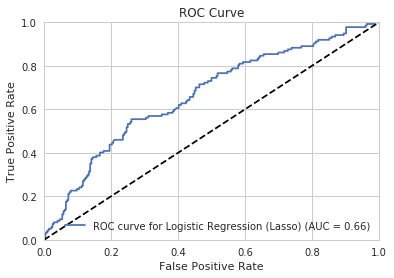

In [17]:
plt_roc_curve("Logistic Regression (Lasso)",log_reg1,has_proba=True)

**Logistic regression (Ridge)**

In [18]:
log_reg2=LogisticRegression(penalty="l2")
log_reg2.fit(x_train,y_train)
predicted=log_reg2.predict(x_test)

print("In-sample accuracy: " + str(prof_train_acc_score(log_reg2)))
print("Test accuracy: " + str(prof_test_acc_score(log_reg2)))
print ("True Positive Rate: " + str(score(log_reg2,"TP")))
print ("True Negative Rate: " + str(score(log_reg2,"TN")))
print ("False Positive Rate: " + str(score(log_reg2,"FP")))
print ("False Negative Rate: " + str(score(log_reg2,"FN")))
print ("Precision Score: " + str(prof_test_prec_score(log_reg2)))
confusion_matrix_model_train(log_reg2)

In-sample accuracy: 0.662831353044
Test accuracy: 0.668280871671
True Positive Rate: 0.06
True Negative Rate: 0.97
False Positive Rate: 0.03
False Negative Rate: 0.94
Precision Score: 0.5


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,1064,486
Predicted Profitable,41,58


In [19]:
confusion_matrix_model(log_reg2)

,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,268,129
Predicted Profitable,8,8


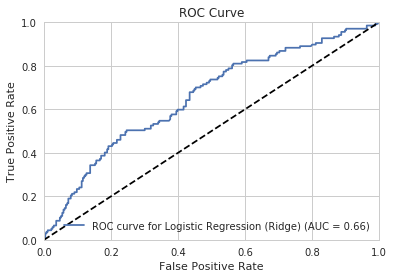

In [20]:
plt_roc_curve("Logistic Regression (Ridge)",log_reg2,has_proba=True)

**SVM**

In [21]:
#param_grid = dict(C=(0.001,0.01,0.1,0.5,1,2,5),gamma=(0.001,0.01,0.1,0.5,1,2,5))
#svc_rbf = GridSearchCV(SVC(kernel="rbf"),param_grid=param_grid,scoring="precision")
svc_rbf = SVC(kernel='rbf', gamma=0.01, C=5,random_state=1000)
svc_rbf.fit(x_train, y_train)
#print(svc_rbf.best_params_)
print("In-sample accuracy: " + str(prof_train_acc_score(svc_rbf)))
print("Test accuracy: " + str(prof_test_acc_score(svc_rbf)))
print ("True Positive Rate: " + str(score(svc_rbf,"TP")))
print ("True Negative Rate: " + str(score(svc_rbf,"TN")))
print ("False Positive Rate: " + str(score(svc_rbf,"FP")))
print ("False Negative Rate: " + str(score(svc_rbf,"FN")))
print ("Precision Score: " + str(prof_test_prec_score(svc_rbf)))
confusion_matrix_model_train(svc_rbf)

In-sample accuracy: 0.668278529981
Test accuracy: 0.673123486683
True Positive Rate: 0.04
True Negative Rate: 0.99
False Positive Rate: 0.01
False Negative Rate: 0.96
Precision Score: 0.625


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,1100,504
Predicted Profitable,5,40


In [22]:
confusion_matrix_model(svc_rbf)

,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,273,132
Predicted Profitable,3,5


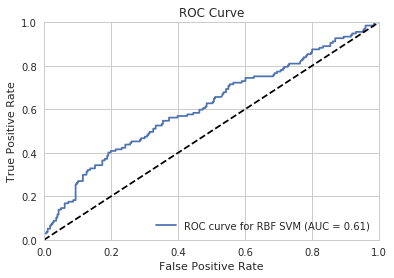

In [23]:
plt_roc_curve("RBF SVM",svc_rbf,has_proba=False)

In [24]:
from sklearn import svm
SVM=svm.LinearSVC(C=5,random_state=10)
SVM.fit(x_train,y_train)
predicted=SVM.predict(x_test)

print("In-sample accuracy: " + str(prof_train_acc_score(SVM)))
print("Test accuracy: " + str(prof_test_acc_score(SVM)))
print ("True Positive Rate: " + str(score(SVM,"TP")))
print ("True Negative Rate: " + str(score(SVM,"TN")))
print ("False Positive Rate: " + str(score(SVM,"FP")))
print ("False Negative Rate: " + str(score(SVM,"FN")))
print ("Precision Score: " + str(prof_test_prec_score(SVM)))
confusion_matrix_model_train(SVM)

In-sample accuracy: 0.528284056369
Test accuracy: 0.668280871671
True Positive Rate: 0.0
True Negative Rate: 1.0
False Positive Rate: 0.0
False Negative Rate: 1.0
Precision Score: 0.0


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,1104,543
Predicted Profitable,1,1


In [25]:
confusion_matrix_model(SVM)

,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,276,137
Predicted Profitable,0,0


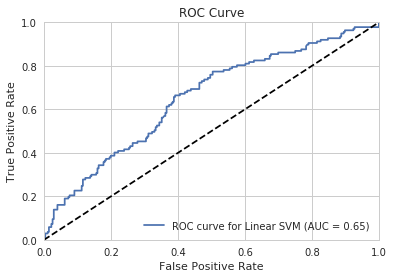

In [26]:
plt_roc_curve("Linear SVM",SVM,has_proba=False)

**KNN**

In [27]:
#param_grid = dict(n_neighbors=np.arange(20,70))
#KNN = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,scoring="precision")
KNN=KNeighborsClassifier(n_neighbors=36)
KNN.fit(x_train,y_train)
predicted=KNN.predict(x_test)
#print(KNN.best_params_)
print("In-sample accuracy: " + str(prof_train_acc_score(KNN)))
print("Test accuracy: " + str(prof_test_acc_score(KNN)))
print ("True Positive Rate: " + str(score(KNN,"TP")))
print ("True Negative Rate: " + str(score(KNN,"TN")))
print ("False Positive Rate: " + str(score(KNN,"FP")))
print ("False Negative Rate: " + str(score(KNN,"FN")))
print ("Precision Score: " + str(prof_test_prec_score(KNN)))
confusion_matrix_model_train(KNN)

In-sample accuracy: 0.662827668785
Test accuracy: 0.668280871671
True Positive Rate: 0.01
True Negative Rate: 1.0
False Positive Rate: 0.0
False Negative Rate: 0.99
Precision Score: 0.5


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,1095,526
Predicted Profitable,10,18


In [28]:
confusion_matrix_model(KNN)

,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,275,136
Predicted Profitable,1,1


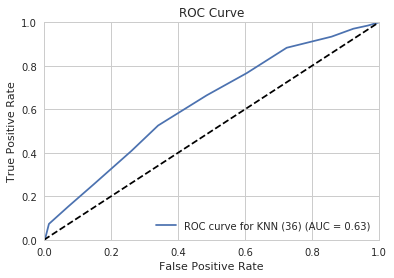

In [29]:
plt_roc_curve("KNN (36)",KNN,has_proba=True)

**Decision Tree/Classification Tree**

In [30]:
#param_grid = dict(max_depth=np.arange(5,10),min_samples_leaf=np.arange(1,8),min_samples_split=np.arange(2,8),max_leaf_nodes=np.arange(60,120,10))
#Dec_tree = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,scoring="precision")
Dec_tree=DecisionTreeClassifier(max_depth= 5, max_leaf_nodes= 90, min_samples_leaf= 1, min_samples_split= 6)
Dec_tree.fit(x_train,y_train)
predicted=Dec_tree.predict(x_test)
#print(Dec_tree.best_params_)
print("In-sample accuracy: " + str(prof_train_acc_score(Dec_tree)))
print("Test accuracy: " + str(prof_test_acc_score(Dec_tree)))
print ("True Positive Rate: " + str(score(Dec_tree,"TP")))
print ("True Negative Rate: " + str(score(Dec_tree,"TN")))
print ("False Positive Rate: " + str(score(Dec_tree,"FP")))
print ("False Negative Rate: " + str(score(Dec_tree,"FN")))
print ("Precision Score: " + str(prof_test_prec_score(Dec_tree)))
confusion_matrix_model_train(Dec_tree)

In-sample accuracy: 0.674337293912
Test accuracy: 0.680387409201
True Positive Rate: 0.13
True Negative Rate: 0.95
False Positive Rate: 0.05
False Negative Rate: 0.87
Precision Score: 0.58064516129


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,1071,452
Predicted Profitable,34,92


In [31]:
confusion_matrix_model(Dec_tree)

,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,263,119
Predicted Profitable,13,18


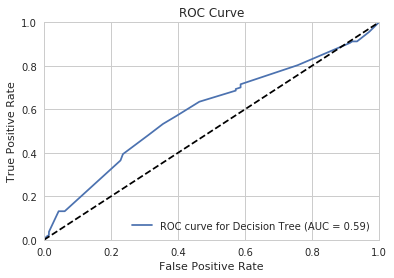

In [32]:
plt_roc_curve("Decision Tree",Dec_tree,has_proba=True)

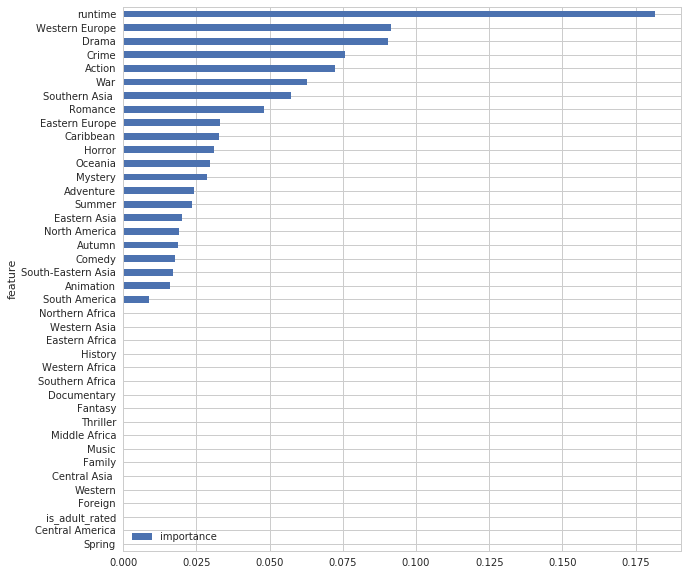

In [33]:
importance_of_features(Dec_tree)

**Random Forest**

In [34]:
#param_grid = dict(max_depth=np.arange(5,10),min_samples_leaf=np.arange(1,10),min_samples_split=np.arange(2,6),max_leaf_nodes=np.arange(50,120,10))
#param_grid = dict(n_estimators = np.arange(50,500,50))
#ranfor = GridSearchCV(RandomForestClassifier(max_depth= 5, max_leaf_nodes= 60, min_samples_leaf= 4, min_samples_split= 3),param_grid=param_grid,scoring="precision")
ranfor = RandomForestClassifier(n_estimators=350,max_depth= 10, max_leaf_nodes= 60, min_samples_leaf= 4, min_samples_split= 3,random_state=20)
ranfor = ranfor.fit(x_train,y_train)
predicted=ranfor.predict(x_test)
#print(ranfor.best_params_)
print("In-sample accuracy: " + str(prof_train_acc_score(ranfor)))
print("Test accuracy: " + str(prof_test_acc_score(ranfor)))
print ("True Positive Rate: " + str(score(ranfor,"TP")))
print ("True Negative Rate: " + str(score(ranfor,"TN")))
print ("False Positive Rate: " + str(score(ranfor,"FP")))
print ("False Negative Rate: " + str(score(ranfor,"FN")))
print ("Precision Score: " + str(prof_test_prec_score(ranfor)))
confusion_matrix_model_train(ranfor)

In-sample accuracy: 0.667674311504
Test accuracy: 0.682808716707
True Positive Rate: 0.06
True Negative Rate: 0.99
False Positive Rate: 0.01
False Negative Rate: 0.94
Precision Score: 0.8


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,1097,475
Predicted Profitable,8,69


In [35]:
confusion_matrix_model(ranfor)

,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,274,129
Predicted Profitable,2,8


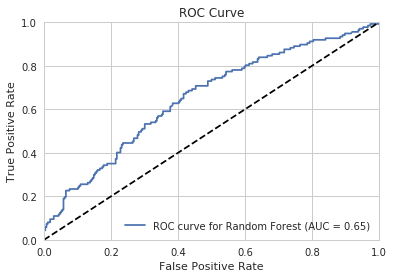

In [36]:
plt_roc_curve("Random Forest",ranfor,has_proba=True)

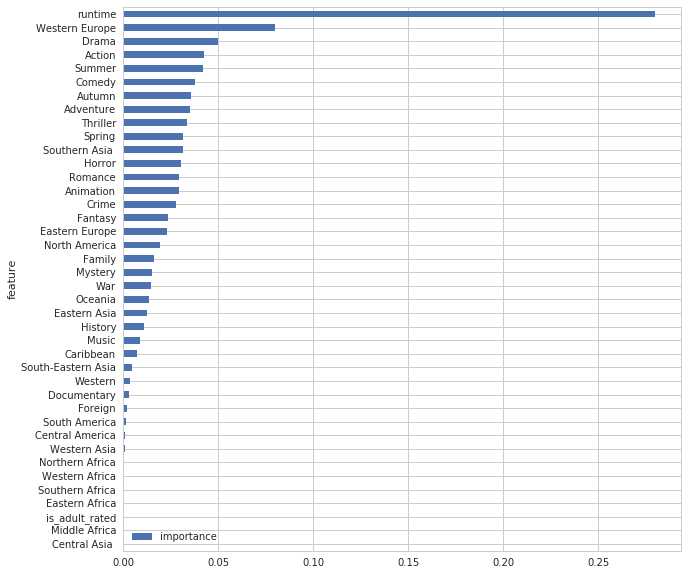

In [37]:
importance_of_features(ranfor)

**XGboosting**

In [38]:
#param_grid = dict(n_estimators=np.arange(50,500,50),max_depth=np.arange(8,12),learning_rate=(0.0001,0.001,0.01,0.1))
#xgclass = GridSearchCV(xgb.XGBClassifier(),param_grid=param_grid,scoring="precision")
xgclass = xgb.XGBClassifier(max_depth=8, n_estimators=300, learning_rate=0.01)
xgclass.fit(x_train,y_train)
predicted=xgclass.predict(x_test)
#print(xgclass.best_params_)
print("In-sample accuracy: " + str(prof_train_acc_score(xgclass)))
print("Test accuracy: " + str(prof_test_acc_score(xgclass)))
print ("True Positive Rate: " + str(score(xgclass,"TP")))
print ("True Negative Rate: " + str(score(xgclass,"TN")))
print ("False Positive Rate: " + str(score(xgclass,"FP")))
print ("False Negative Rate: " + str(score(xgclass,"FN")))
print ("Precision Score: " + str(prof_test_prec_score(xgclass)))
confusion_matrix_model_train(xgclass)

In-sample accuracy: 0.658583402413
Test accuracy: 0.687651331719
True Positive Rate: 0.17
True Negative Rate: 0.95
False Positive Rate: 0.05
False Negative Rate: 0.83
Precision Score: 0.605263157895


,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,1079,346
Predicted Profitable,26,198


In [39]:
confusion_matrix_model(xgclass)

,Actual Not-Profitable,Actual Profitable
Predicted Not-Profitable,261,114
Predicted Profitable,15,23


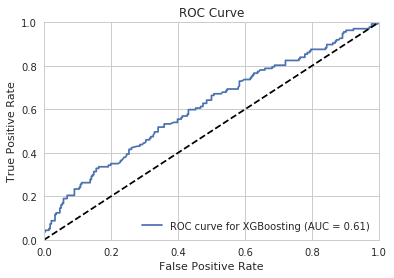

In [40]:
plt_roc_curve("XGBoosting",xgclass,has_proba=True)

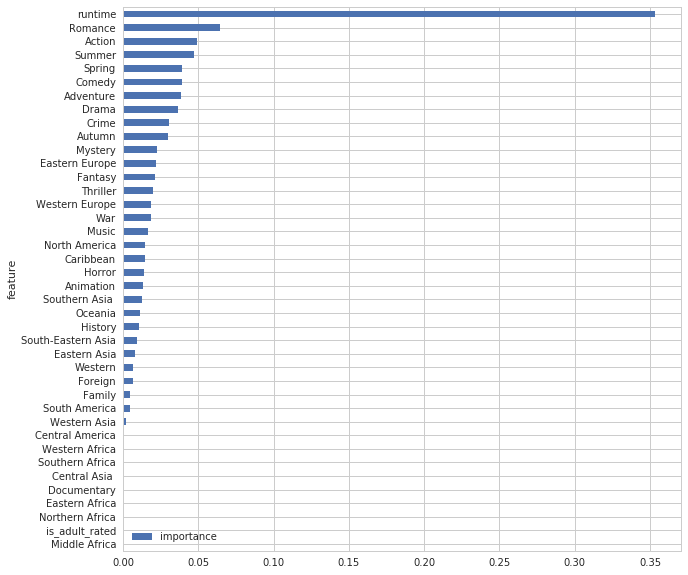

In [41]:
importance_of_features(xgclass)

# 4.1.3 Results for Classification methods for profitability

In [42]:
Classifiers=["Logistic Regression (Lasso)","Logistic Regression (Ridge)","Support Vector Machine (RBF)","Support Vector Machine(Linear)","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[round(prof_train_acc_score(x),2) for x in [log_reg1,log_reg2,svc_rbf,SVM,KNN,Dec_tree,ranfor,xgclass]]
test_acc=[round(prof_test_acc_score(x),2) for x in [log_reg1,log_reg2,svc_rbf,SVM,KNN,Dec_tree,ranfor,xgclass]]
auc_scores_prob=[round(aucscore(x,has_proba=True),2) for x in [log_reg1,log_reg2,KNN,Dec_tree,ranfor,xgclass]]
auc_scores_noprob=[round(aucscore(x,has_proba=False),2) for x in [svc_rbf,SVM]]
auc_scores=auc_scores_prob[:2] + auc_scores_noprob + auc_scores_prob[2:]
TP_rate = [score(x,"TP") for x in [log_reg1,log_reg2,svc_rbf,SVM,KNN,Dec_tree,ranfor,xgclass]]
TN_rate = [score(x,"TN") for x in [log_reg1,log_reg2,svc_rbf,SVM,KNN,Dec_tree,ranfor,xgclass]]
Precision = [round(prof_test_prec_score(x),2) for x in [log_reg1,log_reg2,svc_rbf,SVM,KNN,Dec_tree,ranfor,xgclass]]
cols=["Classifier","In-sample Accuracy","Test Accuracy","AUC","TP Rate","TN Rate","Precision"]
profit_results = pd.DataFrame(columns=cols)
profit_results["Classifier"]=Classifiers
profit_results["In-sample Accuracy"]=in_sample_acc
profit_results["Test Accuracy"]=test_acc
profit_results["AUC"]=auc_scores
profit_results["TP Rate"]=TP_rate
profit_results["TN Rate"]=TN_rate
profit_results["Precision"]=Precision
profit_results

,Classifier,In-sample Accuracy,Test Accuracy,AUC,TP Rate,TN Rate,Precision
0,Logistic Regression (Lasso),0.66,0.67,0.66,0.05,0.98,0.54
1,Logistic Regression (Ridge),0.66,0.67,0.66,0.06,0.97,0.50
2,Support Vector Machine (RBF),0.67,0.67,0.61,0.04,0.99,0.62
3,Support Vector Machine(Linear),0.53,0.67,0.65,0.00,1.00,0.00
4,K-Nearest Neighbours,0.66,0.67,0.63,0.01,1.00,0.50
5,Decision Tree,0.67,0.68,0.59,0.13,0.95,0.58
6,Random Forest,0.67,0.68,0.65,0.06,0.99,0.80
7,XGBoost,0.66,0.69,0.61,0.17,0.95,0.61


# 4.2  Regression and Classification for POPULARITY

# 4.2.1 Multi-Linear Regression

In [43]:
X=valid_data_models.drop(["budget","is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
Y=valid_data_models["Weighted_ratings"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Weighted_ratings   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3069.
Date:                Mon, 16 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:14:28   Log-Likelihood:                -2472.0
No. Observations:                2062   AIC:                             5014.
Df Residuals:                    2027   BIC:                             5211.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
runtime                0.0416      0.001     81.263      0.000       0.041       0.043
Animation              0.8704      0.096      9.072      0.000       0.682       1.059
Crime                  0.0327      0.058      0.566      0.572      -0.081       0.146
History               -0.3260      0.094     -3.468      0.001      -0.510      -0.142
Horror                 0.8852      0.069     12.849      0.000       0.750       1.020
Drama                  0.4002      0.044      9.040      0.000       0.313       0.487
Mystery                0.0545      0.074      0.741      0.459      -0.090       0.199
Documentary            1.2799      0.175      7.310      0.000       0.937       1.623
Fantasy                0.1163      0.068      1.713      0.087      -0.017       0.250
Action                 0.3062      0.048      6.377      0.000       0.212       0.400
Thriller               0.4066      0.048      8.388      0.000       0.312       0.502
Music                  0.0764      0.115      0.665      0.506      -0.149       0.302
Comedy                 0.8158      0.043     19.123      0.000       0.732       0.899
Family                 0.3420      0.083      4.113      0.000       0.179       0.505
Romance                0.0660      0.053      1.250      0.211      -0.038       0.170
Western                0.1465      0.188      0.779      0.436      -0.222       0.516
War                   -0.0196      0.102     -0.192      0.848      -0.220       0.181
Foreign               -0.1769      0.216     -0.818      0.413      -0.601       0.247
Adventure              0.0049      0.056      0.089      0.929      -0.104       0.114
Western Europe         0.1312      0.048      2.729      0.006       0.037       0.225
Middle Africa         -0.6497      0.821     -0.791      0.429      -2.261       0.961
Northern Africa       -0.7611      0.480     -1.587      0.113      -1.702       0.179
Central America       -0.0509      0.246     -0.207      0.836      -0.533       0.431
North America          0.0951      0.080      1.184      0.237      -0.062       0.253
Eastern Asia          -0.0158      0.097     -0.163      0.871      -0.206       0.175
South-Eastern Asia    -0.3541      0.194     -1.826      0.068      -0.734       0.026
Central Asia       -5.822e-16   2.49e-16     -2.338      0.019   -1.07e-15   -9.38e-17
Western Asia           0.4107      0.279      1.470      0.142      -0.137       0.959
Eastern Europe         0.4478      0.087      5.124      0.000       0.276       0.619
Oceania                0.0935      0.114      0.816      0.414      -0.131       0.318
Southern Africa    -1.651e-16   1.21e-16     -1.360      0.174   -4.03e-16     7.3e-17
Southern Asia         -1.2458      0.080    -15.644      0.000      -1.402      -1.090
Caribbean             -0.0688      0.2

**We will first split our training and test set (20%)**

**We will also remove variables that we do not know before a movie is released (e.g profitability, vote counts etc)**

In [44]:
x_pop=valid_data_models.drop(["budget","is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
y_pop=valid_data_models["is_popular"]
x_pop_train,x_pop_test,y_pop_train,y_pop_test=train_test_split(x_pop,y_pop,test_size=0.2,random_state=0)

**We will use 5-fold cross validation**

In [45]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

**We will create functions to calculate the In-sample accuracy, Test accuracy and to plot our ROC curve and confusion matrix for classifying whether a movie would be POPULAR.**

In [46]:
def pop_train_acc_score(model):
    return np.mean(cross_val_score(model,x_pop_train,y_pop_train,cv=k_fold,scoring="accuracy"))
def pop_test_acc_score(model):
    return accuracy_score(y_pop_test, model.predict(x_pop_test))
def pop_test_prec_score(model):
    return precision_score(y_pop_test,model.predict(x_pop_test))
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_pop_test,model_used.predict(x_pop_test))
    col=["Predicted Not-Popular","Predicted Popular"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Popular","Predicted Popular"]
    cm.index=["Actual Not-Popular","Actual Popular"]
    #cm[col]=np(cm[col])
    return cm.T
def confusion_matrix_model_train(model_used):
    cm=confusion_matrix(y_pop_train,model_used.predict(x_pop_train))
    col=["Predicted Not-Popular","Predicted Popular"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Popular","Predicted Popular"]
    cm.index=["Actual Not-Popular","Actual Popular"]
    #cm[col]=np(cm[col])
    return cm.T
def score(model_used,score):
    cm=confusion_matrix(y_pop_test,model_used.predict(x_pop_test))
    col=["Predicted Not-Popular","Predicted Popular"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Popular","Predicted Popular"]
    cm.index=["Actual Not-Popular","Actual Popular"]
    cm[col]=np.around(cm[col].div(cm[col].sum(axis=1),axis=0),decimals=2)
    if str(score) == "TP":
        return cm.loc["Actual Popular","Predicted Popular"]
    elif str(score) == "TN":
        return cm.loc["Actual Not-Popular","Predicted Not-Popular"]   
    elif str(score) == "FP":
        return cm.loc["Actual Not-Popular","Predicted Popular"]
    elif str(score) == "FN":
        return cm.loc["Actual Popular","Predicted Not-Popular"]

def aucscore(model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.predict_proba(x_pop_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.decision_function(x_pop_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc
def plt_roc_curve(name,model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.predict_proba(x_pop_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.decision_function(x_pop_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
def importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_pop_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(10,10))

# 4.2.2 Classification Methods

**Logistic regression (Lasso)**

In [47]:
from sklearn.metrics import accuracy_score
log_reg1_pop=LogisticRegression(penalty="l1")
log_reg1_pop.fit(x_pop_train,y_pop_train)
predicted=log_reg1_pop.predict(x_pop_test)

print("In-sample accuracy: " + str(pop_train_acc_score(log_reg1_pop)))
print("Test accuracy: " + str(pop_test_acc_score(log_reg1_pop)))
print ("True Positive Rate: " + str(score(log_reg1_pop,"TP")))
print ("True Negative Rate: " + str(score(log_reg1_pop,"TN")))
print ("False Positive Rate: " + str(score(log_reg1_pop,"FP")))
print ("False Negative Rate: " + str(score(log_reg1_pop,"FN")))
print ("Precision Score: " + str(pop_test_prec_score(log_reg1_pop)))
confusion_matrix_model_train(log_reg1_pop)

In-sample accuracy: 0.768949065119
Test accuracy: 0.765133171913
True Positive Rate: 0.23
True Negative Rate: 0.96
False Positive Rate: 0.04
False Negative Rate: 0.77
Precision Score: 0.694444444444


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,1197,316
Predicted Popular,47,89


In [48]:
confusion_matrix_model(log_reg1_pop)

,Actual Not-Popular,Actual Popular
Predicted Not-Popular,291,86
Predicted Popular,11,25


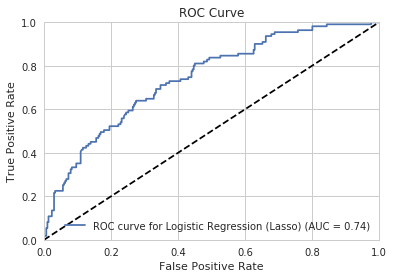

In [49]:
plt_roc_curve("Logistic Regression (Lasso)",log_reg1_pop,has_proba=True)

**Logistic regression (Ridge)**

In [50]:
from sklearn.metrics import accuracy_score
log_reg2_pop=LogisticRegression(penalty="l2")
log_reg2_pop.fit(x_pop_train,y_pop_train)
predicted=log_reg2_pop.predict(x_pop_test)

print("In-sample accuracy: " + str(pop_train_acc_score(log_reg2_pop)))
print("Test accuracy: " + str(pop_test_acc_score(log_reg2_pop)))
print ("True Positive Rate: " + str(score(log_reg2_pop,"TP")))
print ("True Negative Rate: " + str(score(log_reg2_pop,"TN")))
print ("False Positive Rate: " + str(score(log_reg2_pop,"FP")))
print ("False Negative Rate: " + str(score(log_reg2_pop,"FN")))
print ("Precision Score: " + str(pop_test_prec_score(log_reg2_pop)))
confusion_matrix_model_train(log_reg2_pop)

In-sample accuracy: 0.768335635995
Test accuracy: 0.753026634383
True Positive Rate: 0.16
True Negative Rate: 0.97
False Positive Rate: 0.03
False Negative Rate: 0.84
Precision Score: 0.666666666667


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,1214,323
Predicted Popular,30,82


In [51]:
confusion_matrix_model(log_reg2_pop)

,Actual Not-Popular,Actual Popular
Predicted Not-Popular,293,93
Predicted Popular,9,18


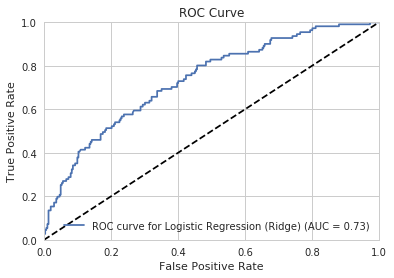

In [52]:
plt_roc_curve("Logistic Regression (Ridge)",log_reg2_pop,has_proba=True)

**SVM**

In [53]:
#param_grid = dict(C=(0.001,0.01,0.1,0.5,1,2,5),gamma=(0.001,0.01,0.1,0.5,1,2,5))
#svc_rbf_pop = GridSearchCV(SVC(kernel="rbf"),param_grid=param_grid,scoring="precision")
svc_rbf_pop = SVC(kernel='rbf', gamma=0.01, C=2,random_state=1000)
svc_rbf_pop.fit(x_pop_train, y_pop_train)
#print(svc_rbf_pop.best_params_)
print("In-sample accuracy: " + str(pop_train_acc_score(svc_rbf_pop)))
print("Test accuracy: " + str(pop_test_acc_score(svc_rbf_pop)))
print ("True Positive Rate: " + str(score(svc_rbf_pop,"TP")))
print ("True Negative Rate: " + str(score(svc_rbf_pop,"TN")))
print ("False Positive Rate: " + str(score(svc_rbf_pop,"FP")))
print ("False Negative Rate: " + str(score(svc_rbf_pop,"FN")))
print ("Precision Score: " + str(pop_test_prec_score(svc_rbf_pop)))
confusion_matrix_model_train(svc_rbf_pop)

In-sample accuracy: 0.764087685364
Test accuracy: 0.733656174334
True Positive Rate: 0.11
True Negative Rate: 0.96
False Positive Rate: 0.04
False Negative Rate: 0.89
Precision Score: 0.521739130435


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,1231,362
Predicted Popular,13,43


In [54]:
confusion_matrix_model(svc_rbf_pop)

,Actual Not-Popular,Actual Popular
Predicted Not-Popular,291,99
Predicted Popular,11,12


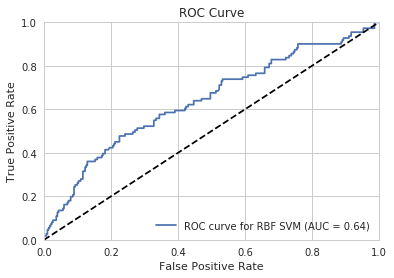

In [55]:
plt_roc_curve("RBF SVM",svc_rbf_pop,has_proba=False)

In [56]:
from sklearn import svm
SVM_pop=svm.LinearSVC(C=0.1,random_state=1000)
SVM_pop.fit(x_pop_train,y_pop_train)
predicted=SVM_pop.predict(x_pop_test)

print("In-sample accuracy: " + str(pop_train_acc_score(SVM_pop)))
print("Test accuracy: " + str(pop_test_acc_score(SVM_pop)))
print ("True Positive Rate: " + str(score(SVM_pop,"TP")))
print ("True Negative Rate: " + str(score(SVM_pop,"TN")))
print ("False Positive Rate: " + str(score(SVM_pop,"FP")))
print ("False Negative Rate: " + str(score(SVM_pop,"FN")))
print ("Precision Score: " + str(pop_test_prec_score(SVM_pop)))
confusion_matrix_model_train(SVM_pop)

In-sample accuracy: 0.690761720549
Test accuracy: 0.556900726392
True Positive Rate: 0.82
True Negative Rate: 0.46
False Positive Rate: 0.54
False Negative Rate: 0.18
Precision Score: 0.358267716535


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,552,54
Predicted Popular,692,351


In [57]:
confusion_matrix_model(SVM_pop)

,Actual Not-Popular,Actual Popular
Predicted Not-Popular,139,20
Predicted Popular,163,91


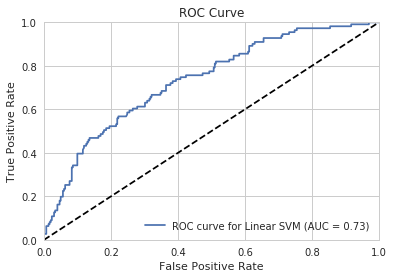

In [58]:
plt_roc_curve("Linear SVM",SVM_pop,has_proba=False)

**KNN**

In [59]:
#param_grid = dict(n_neighbors=np.arange(20,70))
#KNN_pop = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,scoring="precision")
KNN_pop=KNeighborsClassifier(n_neighbors=57)
KNN_pop.fit(x_pop_train,y_pop_train)
predicted=KNN_pop.predict(x_pop_test)
#print(KNN_pop.best_params_)
print("In-sample accuracy: " + str(pop_train_acc_score(KNN_pop)))
print("Test accuracy: " + str(pop_test_acc_score(KNN_pop)))
print ("True Positive Rate: " + str(score(KNN_pop,"TP")))
print ("True Negative Rate: " + str(score(KNN_pop,"TN")))
print ("False Positive Rate: " + str(score(KNN_pop,"FP")))
print ("False Negative Rate: " + str(score(KNN_pop,"FN")))
print ("Precision Score: " + str(pop_test_prec_score(KNN_pop)))
confusion_matrix_model_train(KNN_pop)

In-sample accuracy: 0.751351201989
Test accuracy: 0.72397094431
True Positive Rate: 0.07
True Negative Rate: 0.96
False Positive Rate: 0.04
False Negative Rate: 0.93
Precision Score: 0.421052631579


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,1224,375
Predicted Popular,20,30


In [60]:
confusion_matrix_model(KNN_pop)

,Actual Not-Popular,Actual Popular
Predicted Not-Popular,291,103
Predicted Popular,11,8


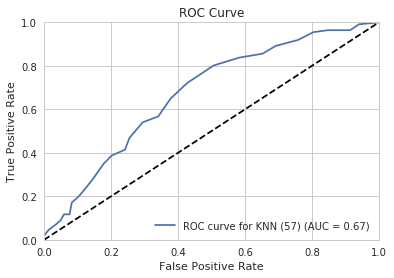

In [61]:
plt_roc_curve("KNN (57)",KNN_pop,has_proba=True)

**Decision Tree/Classification Tree**

In [62]:
#param_grid = dict(max_depth=np.arange(4,10),min_samples_leaf=np.arange(2,20),min_samples_split=np.arange(2,8),max_leaf_nodes=np.arange(40,100,10))
#Dec_tree_pop = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,scoring="precision")
Dec_tree_pop=DecisionTreeClassifier(max_depth=7, max_leaf_nodes= 40, min_samples_leaf= 13, min_samples_split= 3,random_state=100)
Dec_tree_pop.fit(x_pop_train,y_pop_train)
predicted=Dec_tree_pop.predict(x_pop_test)
#print(Dec_tree_pop.best_params_)
print("In-sample accuracy: " + str(pop_train_acc_score(Dec_tree_pop)))
print("Test accuracy: " + str(pop_test_acc_score(Dec_tree_pop)))
print ("True Positive Rate: " + str(score(Dec_tree_pop,"TP")))
print ("True Negative Rate: " + str(score(Dec_tree_pop,"TN")))
print ("False Positive Rate: " + str(score(Dec_tree_pop,"FP")))
print ("False Negative Rate: " + str(score(Dec_tree_pop,"FN")))
print ("Precision Score: " + str(pop_test_prec_score(Dec_tree_pop)))
confusion_matrix_model_train(Dec_tree_pop)

In-sample accuracy: 0.75437966289
Test accuracy: 0.73607748184
True Positive Rate: 0.23
True Negative Rate: 0.92
False Positive Rate: 0.08
False Negative Rate: 0.77
Precision Score: 0.520833333333


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,1175,257
Predicted Popular,69,148


In [63]:
confusion_matrix_model(Dec_tree_pop)

,Actual Not-Popular,Actual Popular
Predicted Not-Popular,279,86
Predicted Popular,23,25


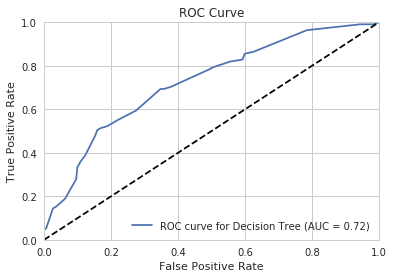

In [64]:
plt_roc_curve("Decision Tree",Dec_tree_pop,has_proba=True)

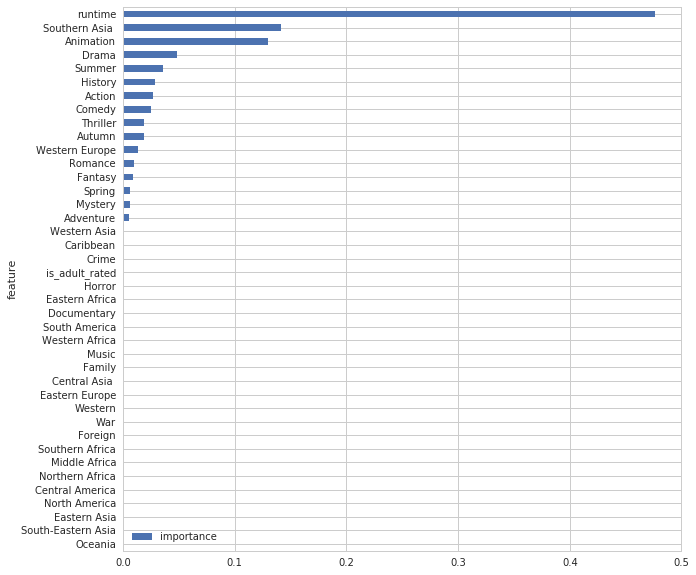

In [65]:
importance_of_features(Dec_tree_pop)

**Random Forest**

In [66]:
#param_grid = dict(max_depth=np.arange(5,10),min_samples_leaf=np.arange(1,10),min_samples_split=np.arange(2,6),max_leaf_nodes=np.arange(50,120,10))
#param_grid = dict(n_estimators = np.arange(50,500,50))
#ranfor_pop = GridSearchCV(RandomForestClassifier(max_depth= 5, max_leaf_nodes= 80, min_samples_leaf= 5, min_samples_split= 2),param_grid=param_grid,scoring="precision")
ranfor_pop = RandomForestClassifier(n_estimators=50,max_depth=5, max_leaf_nodes=80, min_samples_leaf=5, min_samples_split= 2,random_state=30)
ranfor_pop = ranfor_pop.fit(x_pop_train,y_pop_train)
predicted=ranfor_pop.predict(x_pop_test)
#print(ranfor_pop.best_params_)
print("In-sample accuracy: " + str(pop_train_acc_score(ranfor_pop)))
print("Test accuracy: " + str(pop_test_acc_score(ranfor_pop)))
print ("True Positive Rate: " + str(score(ranfor_pop,"TP")))
print ("True Negative Rate: " + str(score(ranfor_pop,"TN")))
print ("False Positive Rate: " + str(score(ranfor_pop,"FP")))
print ("False Negative Rate: " + str(score(ranfor_pop,"FN")))
print ("Precision Score: " + str(pop_test_prec_score(ranfor_pop)))
confusion_matrix_model_train(ranfor_pop)

In-sample accuracy: 0.761066592981
Test accuracy: 0.740920096852
True Positive Rate: 0.05
True Negative Rate: 0.99
False Positive Rate: 0.01
False Negative Rate: 0.95
Precision Score: 0.75


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,1241,380
Predicted Popular,3,25


In [67]:
confusion_matrix_model(ranfor_pop)

,Actual Not-Popular,Actual Popular
Predicted Not-Popular,300,105
Predicted Popular,2,6


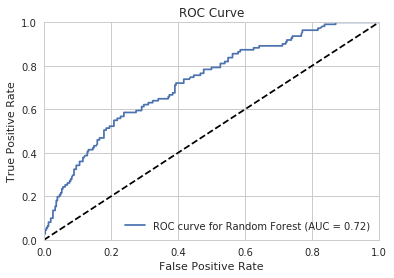

In [68]:
plt_roc_curve("Random Forest",ranfor_pop,has_proba=True)

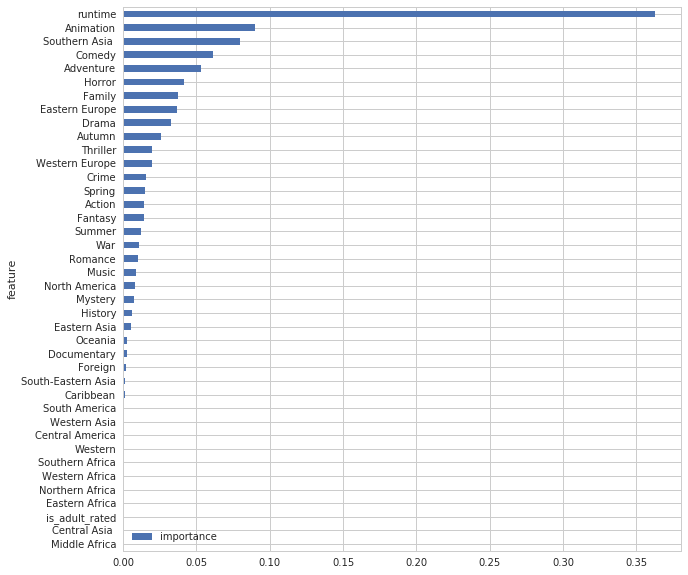

In [69]:
importance_of_features(ranfor_pop)

**XGBoosting**

In [70]:
#param_grid = dict(n_estimators=np.arange(50,500,50),max_depth=np.arange(6,10),learning_rate=(0.0001,0.001,0.01,0.1))
#xgclass_pop = GridSearchCV(xgb.XGBClassifier(),param_grid=param_grid,scoring="precision")
xgclass_pop = xgb.XGBClassifier(max_depth=3, n_estimators=50, learning_rate=0.1)
xgclass_pop.fit(x_pop_train,y_pop_train)
predicted=xgclass_pop.predict(x_pop_test)
#print(xgclass_pop.best_params_)
print("In-sample accuracy: " + str(pop_train_acc_score(xgclass_pop)))
print("Test accuracy: " + str(pop_test_acc_score(xgclass_pop)))
print ("True Positive Rate: " + str(score(xgclass_pop,"TP")))
print ("True Negative Rate: " + str(score(xgclass_pop,"TN")))
print ("False Positive Rate: " + str(score(xgclass_pop,"FP")))
print ("False Negative Rate: " + str(score(xgclass_pop,"FN")))
print ("Precision Score: " + str(pop_test_prec_score(xgclass_pop)))
confusion_matrix_model_train(xgclass_pop)

In-sample accuracy: 0.776818642351
Test accuracy: 0.755447941889
True Positive Rate: 0.24
True Negative Rate: 0.94
False Positive Rate: 0.06
False Negative Rate: 0.76
Precision Score: 0.613636363636


,Actual Not-Popular,Actual Popular
Predicted Not-Popular,1199,282
Predicted Popular,45,123


In [71]:
confusion_matrix_model(xgclass_pop)

,Actual Not-Popular,Actual Popular
Predicted Not-Popular,285,84
Predicted Popular,17,27


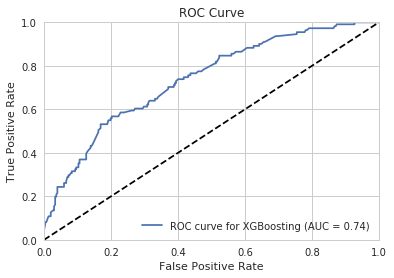

In [72]:
plt_roc_curve("XGBoosting",xgclass_pop,has_proba=True)

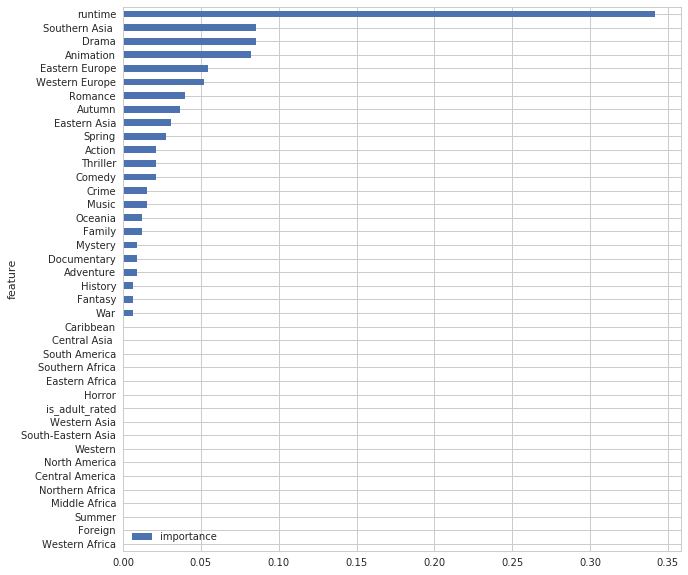

In [73]:
importance_of_features(xgclass_pop)

# 4.2.3 Results for Classification methods for popularity

In [74]:
Classifiers=["Logistic Regression (Lasso)","Logistic Regression (Ridge)","Support Vector Machine (Rbf)","Support Vector Machine(Linear)","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[round(pop_train_acc_score(x),2) for x in [log_reg1_pop,log_reg2_pop,svc_rbf_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
test_acc=[round(pop_test_acc_score(x),2) for x in [log_reg1_pop,log_reg2_pop,svc_rbf_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
auc_scores_prob=[round(aucscore(x,has_proba=True),2) for x in [log_reg1_pop,log_reg2_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
auc_scores_noprob=[round(aucscore(x,has_proba=False),2) for x in [svc_rbf_pop,SVM_pop]]
auc_scores=auc_scores_prob[:2] + auc_scores_noprob + auc_scores_prob[2:]
TP_rate = [score(x,"TP") for x in [log_reg1_pop,log_reg2_pop,svc_rbf_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
TN_rate = [score(x,"TN") for x in [log_reg1_pop,log_reg2_pop,svc_rbf_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
Precision = [round(pop_test_prec_score(x),2) for x in [log_reg1_pop,log_reg2_pop,svc_rbf_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
cols=["Classifier","In-sample Accuracy","Test Accuracy","AUC"]
popularity_results = pd.DataFrame(columns=cols)
popularity_results["Classifier"]=Classifiers
popularity_results["In-sample Accuracy"]=in_sample_acc
popularity_results["Test Accuracy"]=test_acc
popularity_results["AUC"]=auc_scores
popularity_results["TP Rate"]=TP_rate
popularity_results["TN Rate"]=TN_rate
popularity_results["Precision"]=Precision
popularity_results

,Classifier,In-sample Accuracy,Test Accuracy,AUC,TP Rate,TN Rate,Precision
0,Logistic Regression (Lasso),0.77,0.77,0.74,0.23,0.96,0.69
1,Logistic Regression (Ridge),0.77,0.75,0.73,0.16,0.97,0.67
2,Support Vector Machine (Rbf),0.76,0.73,0.64,0.11,0.96,0.52
3,Support Vector Machine(Linear),0.69,0.56,0.73,0.82,0.46,0.36
4,K-Nearest Neighbours,0.75,0.72,0.67,0.07,0.96,0.42
5,Decision Tree,0.75,0.74,0.72,0.23,0.92,0.52
6,Random Forest,0.76,0.74,0.72,0.05,0.99,0.75
7,XGBoost,0.78,0.76,0.74,0.24,0.94,0.61
